In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import requests
import json
import datetime
%matplotlib inline

In [2]:
graffiti = pd.read_csv('graffitti.csv')
buildings = pd.read_csv('buildings.csv')
potholes = pd.read_csv('potholes.csv')
sanitation = pd.read_csv('sanitation.csv')
areas = pd.read_csv('areas.csv')[['community_area', 'community']]

service_calls = pd.concat([graffiti, buildings, potholes, sanitation]).merge(areas, on='community_area')

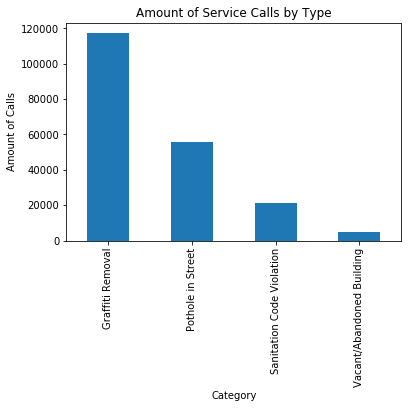

In [3]:
calls_by_type = service_calls.groupby('type_service').size().plot(kind='bar', title="Amount of Service Calls by Type")
plt.xlabel("Category")
plt.ylabel("Amount of Calls")

Sanitation is the only category that has subtypes, so I plotted the types of sanitation requests:

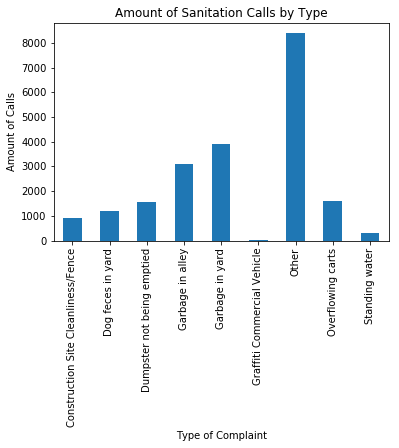

In [4]:
sanitation.groupby('sanitation_violation').size().plot(kind='bar')
plt.title("Amount of Sanitation Calls by Type")
plt.ylabel("Amount of Calls")
plt.xlabel("Type of Complaint")

In [5]:
community_by_calls = pd.DataFrame(service_calls.groupby('community').size()).reset_index().sort_values(by=0, axis=0)
community_by_calls.columns=['Community','Total Calls']
community_by_calls[:10]

,Community,Total Calls
55,OAKLAND,106
25,FULLER PARK,209
59,RIVERDALE,216
12,BURNSIDE,228
36,KENWOOD,308
17,DOUGLAS,323
68,WASHINGTON PARK,335
56,OHARE,370
58,PULLMAN,383
44,MONTCLARE,616


In [6]:
community_by_calls[-10:]

,Community,Total Calls
26,GAGE PARK,4900
8,BELMONT CRAGIN,5098
34,IRVING PARK,5874
42,LOWER WEST SIDE,6009
37,LAKE VIEW,6225
7,AVONDALE,6303
11,BRIGHTON PARK,6648
64,SOUTH LAWNDALE,6738
40,LOGAN SQUARE,9660
75,WEST TOWN,12396


In [7]:
services_by_community = pd.DataFrame(service_calls.groupby(['community', 'type_service']).size())

In [8]:
pd.DataFrame(service_calls.groupby(['community', 'sanitation_violation']).size())

0
community      sanitation_violation                    
ALBANY PARK    Construction Site Cleanliness/Fence   10
               Dog feces in yard                     13
               Dumpster not being emptied            54
               Garbage in alley                      65
               Garbage in yard                       40
               Graffiti Commercial Vehicle            1
               Other                                 78
               Overflowing carts                     41
               Standing water                         3
ARCHER HEIGHTS Construction Site Cleanliness/Fence    3
               Dog feces in yard                     19
               Dumpster not being emptied             5
               Garbage in alley                      71
               Garbage in yard                       45
               Graffiti Commercial Vehicle            8
               Other                                294
               Overflowing carts                     31
               Standing water                        68
ARMOUR SQUARE  Construction Site Cleanliness/Fence    4
               Dog feces in yard                      1
               Dumpster not being emptied             3
               Garbage in alley                      14
               Garbage in yard                        5
               Other                                 46
               Overflowing carts                      6
ASHBURN        Construction Site Cleanliness/Fence    4
               Dog feces in yard                     46
               Dumpster not being emptied            11
               Garbage in alley                      30
               Garbage in yard                       54
...                                                 ...
WEST PULLMAN   Dumpster not being emptied             7
               Garbage in alley                      40
               Garbage in yard                       94
               Other                                206
               Overflowing carts                     44
               Standing water                         7
WEST RIDGE     Construction Site Cleanliness/Fence   15
               Dog feces in yard                     11
               Dumpster not being emptied            47
               Garbage in alley                      94
               Garbage in yard                      112
               Other                                124
               Overflowing carts                     53
               Standing water                         4
WEST TOWN      Construction Site Cleanliness/Fence   81
               Dog feces in yard                     48
               Dumpster not being emptied            74
               Garbage in alley                     133
               Garbage in yard                       76
               Graffiti Commercial Vehicle            2
               Other                                284
               Overflowing carts                     36
               Standing water                        18
WOODLAWN       Construction Site Cleanliness/Fence    9
               Dog feces in yard                      7
               Dumpster not being emptied            38
               Garbage in alley                      42
               Garbage in yard                       60
               Other                                102
               Overflowing carts                     42

[607 rows x 1 columns]

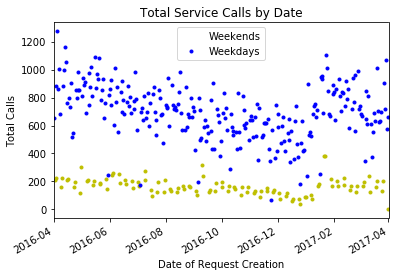

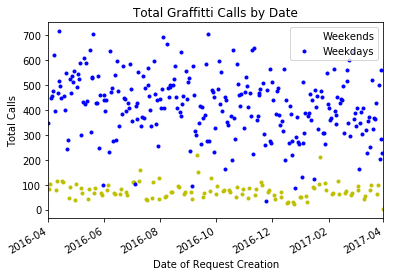

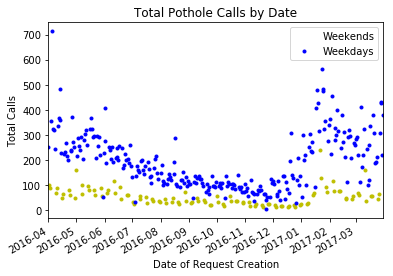

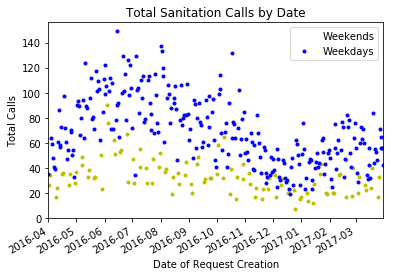

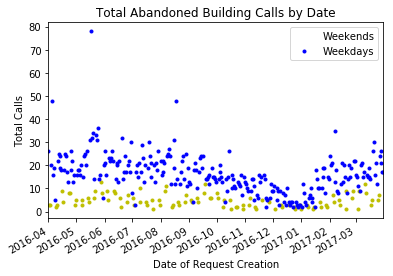

In [9]:
def plot_by_date(df, title):
    fig, ax = plt.subplots()
    calls_by_date = df.groupby('create_date').size().reset_index()
    calls_by_date.create_date = pd.to_datetime(calls_by_date.create_date)
    calls_by_date['create_weekday'] = calls_by_date.create_date.dt.dayofweek
    calls_by_date[calls_by_date['create_weekday'].isin([5,6])].plot(x='create_date', y=0, style='.', ax=ax, color='y', label="Weekends")
    calls_by_date[calls_by_date['create_weekday'].isin(range(0,5))].plot(x='create_date', y=0, style='.', ax=ax, color='b', label="Weekdays")
    plt.title(title)
    plt.xlabel("Date of Request Creation")
    plt.ylabel("Total Calls")
plot_by_date(service_calls, "Total Service Calls by Date")
plot_by_date(graffiti, "Total Graffitti Calls by Date")
plot_by_date(potholes, "Total Pothole Calls by Date")
plot_by_date(sanitation, "Total Sanitation Calls by Date")
plot_by_date(buildings, "Total Abandoned Building Calls by Date")


In [10]:
service_calls.complete_date = pd.to_datetime(service_calls.complete_date)
service_calls.create_date = pd.to_datetime(service_calls.create_date)

In [11]:
service_calls['time_to_complete'] = (service_calls.complete_date - service_calls.create_date).astype('timedelta64[D]')

In [12]:
service_calls[['type_service','time_to_complete']].groupby('type_service').mean()

,time_to_complete
type_service,
Graffiti Removal,0.668074
Pothole in Street,23.426094
Sanitation Code Violation,8.842682
Vacant/Abandoned Building,NaN


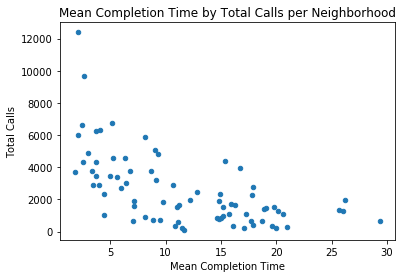

In [13]:
mean_completion_by_community = service_calls[['community','time_to_complete']].groupby('community').mean().reset_index().sort_values(by='time_to_complete', axis=0)
mean_completion_by_community.columns=['Community','Mean Completion Time']
complete_by_total = mean_completion_by_community.merge(community_by_calls, on='Community')
complete_by_total.plot(kind='scatter', x='Mean Completion Time', y="Total Calls")
plt.title("Mean Completion Time by Total Calls per Neighborhood")

Some interesting things I learned from this:

1. There's a huge gap in service call requests between weekdays and weekends, mostly for graffitti requests. My intuition would have told me that more graffitti is actually spraypainted on weekends, since there is likely to be more free time then. My best answer to *why* there are more service calls during weeks is institutional, it's possible that most requests are processed during the week and calls on the weekends are just likely to be entered in later on. 

2. I was surprised how quickly graffitti requests were responded to. The mean response time was less than a day. I am not at all surprised about the pothole mean completion time.

3. My plot above shows that there is some relationship between the amount of calls and the completion time. Shorter completion time seems to be associated with more calls, though just from this, I have no idea if one causes the other, and if so, which factor is the cause and which is the effect. 

4. This is a bit more qualitative, but the top 10 highest service call nighborhoods seem to be more from the North Side, while the bottom 10 neighborhoods seem to be mostly from the South Side. 

5. Service calls also track with the seasons, except graffitti. This again goes against my intuition, as I would expect more graffitti in the summer and very little in the winter. I also don't have a potential institutional explanation for this.

In [14]:
def get_fips(row):
    try:
        response = requests.get('https://www.broadbandmap.gov/broadbandmap/census/block?latitude='+str(row['lat'])+'&longitude='+str(row['long'])+'&format=json')
        result = response.json()
        return result['Results']['block'][0]['FIPS'][:13]
    except:
        return None

In [15]:
year_calls = service_calls[service_calls['create_date'] > datetime.datetime(year=2017, month=1, day=1)]
year_calls = year_calls[year_calls['type_service'].isin(['Sanitation Code Violation', 'Vacant/Abandoned Building'])]

In [ ]:
# year_calls['FIPS'] = year_calls.apply(get_fips, axis=1)
# I saved my API call|s so I could reload this later, I used the original line above to make the calls though
year_calls = pd.read_csv('year_calls.csv')
year_calls.complete_date = pd.to_datetime(year_calls.complete_date)
year_calls.create_date = pd.to_datetime(year_calls.create_date)

In [ ]:
url = 'https://api.census.gov/data/2015/acs5?get=NAME,B01001_001E,B20002_001E,B01002_001E&for=block+group:*&in=state:17+county:031'
response = requests.get(url)
blocks = response.json()
blocks = pd.DataFrame(blocks).drop(0, axis=0)
blocks.columns = ['Name', 'Total Population', 'Median earnings in the past 12 months', 'Median age', 'state', 'county', 'tract', 'block_group']
blocks['FIPS'] = blocks.state + blocks.county + blocks.tract + blocks.block_group
blocks['FIPS'] = pd.to_numeric(blocks['FIPS'])
blocks['Total Population'] = pd.to_numeric(blocks['Total Population'])
blocks['Median earnings in the past 12 months'] = pd.to_numeric(blocks['Median earnings in the past 12 months'])
blocks['Median age'] = pd.to_numeric(blocks['Median age'])


In [ ]:
building_fips = pd.DataFrame(year_calls[year_calls['type_service'] == 'Vacant/Abandoned Building'].groupby(['FIPS']).size()).reset_index().merge(blocks, on='FIPS')

In [ ]:
building_fips.plot(x='Median age', y=0, style='.')
plt.xlim(15,)

In [ ]:
building_fips.plot(x='Median earnings in the past 12 months', y=0, style='.')
plt.xlim(0,100000)

In [ ]:
building_fips.plot(x='Total Population', y=0, style='.')
plt.xlim(0,4000)

1. There appears to be a negative relationship between the amount of vacant house calls and the amount of people living in a block. There also appears to be a negative relationship between median annual earnings for residents of a block and the amount of vacant house calls. Finally, there is a positive relationship between age and vacant house calls.

In [ ]:
sanitation_fips = pd.DataFrame(year_calls[year_calls['type_service'] == 'Sanitation Code Violation'].groupby(['FIPS']).size()).reset_index().merge(blocks, on='FIPS')

In [ ]:
sanitation_fips.plot(x='Median age', y=0, style='.')
plt.xlim(15,)
plt.ylim(0,20)

In [ ]:
sanitation_fips.plot(x='Median earnings in the past 12 months', y=0, style='.')
plt.xlim(0,100000)
plt.ylim(0,20)

In [ ]:
sanitation_fips.plot(x='Total Population', y=0, style='.')
plt.xlim(0,4000)
plt.ylim(0,20)

2. The patterns from vacant house calls are similar to those for sanitation calls: 
    a. Negative relationship between population and santition calls
    b. Negative relationship between earnings and sanitation calls
    c. Positive relationship between age and sanitation calls

In [ ]:
merge_year_calls = year_calls.merge(blocks, on='FIPS')

In [ ]:
merge_year_calls.plot(x='create_date', y='Total Population', style='.')

In [ ]:
merge_year_calls.plot(x='create_date', y='Median age', style='.')

In [ ]:
merge_year_calls.plot(x='create_date', y='Median earnings in the past 12 months', style='.')

3. In each of these plots, we see that blocks with more people, higher earnings and higher age seem to dip once each week, presumably on weekends. This might mean that those in these populations are more likely to stay at home those days than to be out of their homes and experiencing problems. 

4. Overall, we see that similar trends hold for both sanitation calls and vacant housing calls. Whenever the population is higher or earns more, we see less calls, while the older the population, the more frequently calls are made.

Part 3: 7500 S. Wolcott Ave. is in the Auburn Gresham neighborhood. We'll have to use the community area information for this,
because I was not able to run calls for graffitti and potholes on the ACS API.

In [ ]:
def percent_of_calls(service):
    return (service / auburn[0].sum()) * 100

#services_by_community.reset_index(inplace=True)
auburn = services_by_community[services_by_community['community'] == 'AUBURN GRESHAM']
total_auburn_calls = auburn[0].sum()
auburn['percent'] = auburn[0].apply(percent_of_calls)
auburn

A. Most likely, the call is about a pothole, followed by a sanitation code violation, followed by a vacant building 
and finally, about graffiti removal.

lawndale = services_by_community[services_by_community['community'].isin(['NORTH LAWNDALE', 'SOUTH LAWNDALE'])]
lawndale = lawndale.groupby('type_service').sum().reset_index()
lawndale_graffiti_total = lawndale[lawndale['type_service']=='Graffiti Removal'][0].sum()

In [ ]:
uptown = services_by_community[services_by_community['community'] =='UPTOWN']
uptown_graffiti_total = uptown[uptown['type_service']=='Graffiti Removal'][0].sum()

In [ ]:
uptown_graffiti_ratio = uptown_graffiti_total / (uptown_graffiti_total + lawndale_graffiti_total)
lawndale_graffiti_ratio = lawndale_graffiti_total / (uptown_graffiti_total + lawndale_graffiti_total)
print(uptown_graffiti_ratio)
print(lawndale_graffiti_ratio)

It seems that Lawndale is more likely to be the source of the graffiti complaint.

There are a total of 1000 calls, 600 from Englewood and 400 from Uptown. Of the 600 calls from Englewood, 100 of them are about Graffiti Removal. Of the 400 calls from Uptown, 160 are about Graffiti Removal. If a call comes about Graffiti Removal, how much more/less likely is it that the call came from Englewood versus Uptown? 

0.2 of the graffiti calls come from Englewood
0.8 of the graffiti calls come from Uptown

In this case, it is more likely that the call comes from Uptown than it comes from Englewood. 